In [2]:
# Common imports
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

# Facial recognition with Principal Component Analysis

Principal Component Analysis (PCA) is a method of exploratory data analysis which constructs an orthogonal basis for the data that best captures its variance. PCA removes redundant dimensions in high-dimensional datasets and, like SVD, prioritizes features of the data that give the largest contributions to the variety of information. This allows us to reduce the dimension we consider for a clearer understanding of the dataset's nature and thus a better ability to build a predictive model for future data.

![PCA of a multivariate Gaussian distribution centered at (1,3)](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/GaussianScatterPCA.svg/600px-GaussianScatterPCA.svg.png)

*PCA of a multivariate Gaussian distribution centered at $(1,3)$. The vectors shown are the eigenvectors of the covariance matrix scaled by the square root of the corresponding eigenvalue, and shifted so their tails are at the mean.*

In this notebook, we will use PCA to analyze the collection of face images and construct a simple machine learning model to classify unlabelled images of faces. *This is a more advanced version of the task in the Perceptron notebook for binary classification of MNIST digits.*

We will be using AT&T Laboratories Cambridge's (previously known as Olivetti Research Laboratory) ["Database of Faces"](https://web.archive.org/web/20180802044943/http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html). This is a set of greyscale face images, each normalized to the same resolution, and each face taking up the same relative amount of area in each image.

In [3]:
# Import data
faces = np.loadtxt('./faces.txt')
labels = np.loadtxt('./labels.txt').astype(int)

The 2d NumPy array `faces` contains each face image as a row. Pictures of 40 people are included, and each person is represented with 9 different face images in the set. The images have been flattened into long vectors for better handling, but you will see below that we may reshape and plot them for human visualization.

The 1d NumPy array `labels` contains the numerical labels for the people captured by the corresponding rows in `faces`.

In [4]:
faces.shape

(360, 10304)

In [5]:
labels.shape

(360,)

Below we visualize a few of the faces.

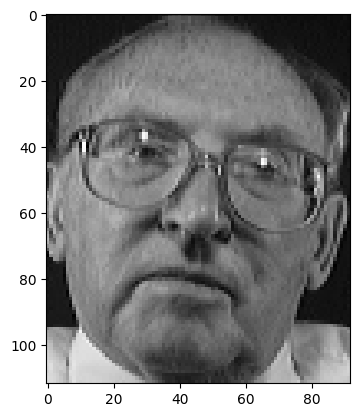

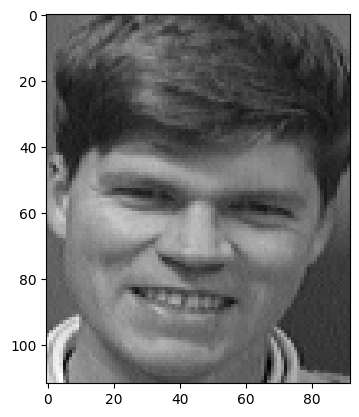

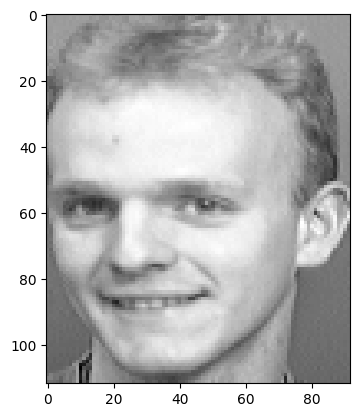

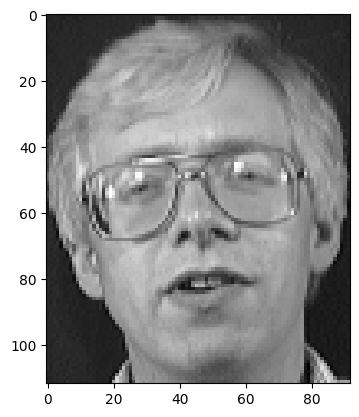

In [6]:
face_shape = (112, 92)
for i in [0,10,20,30]:
    # Reshape face into 2d NumPy array for proper visualization
    face = faces[i].reshape(face_shape)
    # Display the face
    plt.figure()
    plt.imshow(face, cmap="gray")

## 1) Preparing the faces

Recall that PCA requires a zero-mean dataset. We could further normalize to a unit-variance dataset, but in this case, doing so would equalize the impact of differences among the images in the corners with the differences among pixels nearer to the center, where we can safely say the core features of the faces lie. So we will only seek out a zero-mean dataset here.

- Compute the average face across all of the of the given faces. Store this as the 1d NumPy array `face_avg`. **This step computes an average, multidimensional data point.**

In [7]:
# take the mean of all the rows of the faces array. 
# This will give us a 1D NumPy array of shape (10304,) which represents the average face.
face_avg = faces.mean(axis=0) 

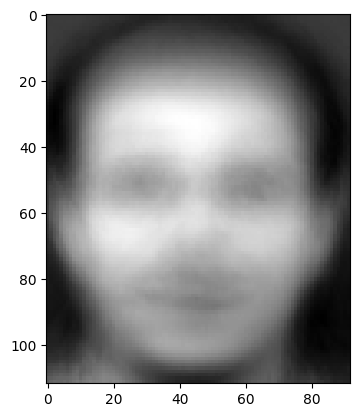

In [8]:
plt.imshow(face_avg.reshape(face_shape), cmap="gray")

- Construct the normalized dataset `faces_nrm` corresponding to `faces` as a zero-mean dataset. **This step arithmetically normalizes a dataset.**

In [9]:
# Subtract the average face from all faces
faces_nrm = faces - face_avg

We can peruse how some of the normalized faces look.

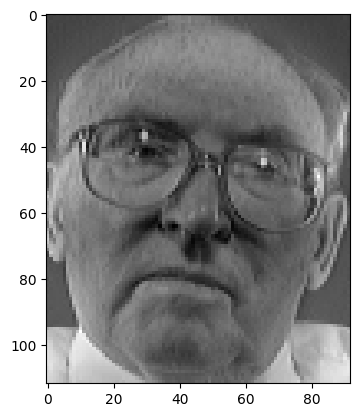

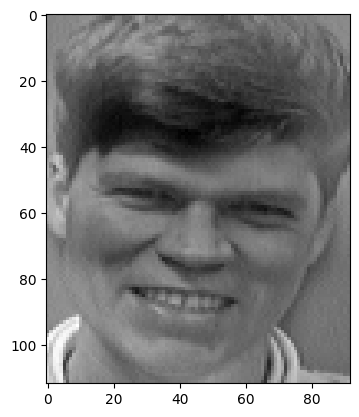

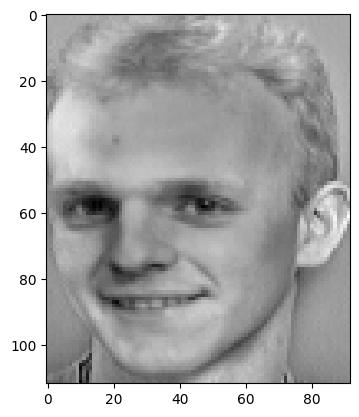

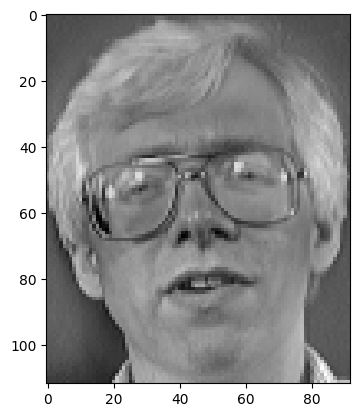

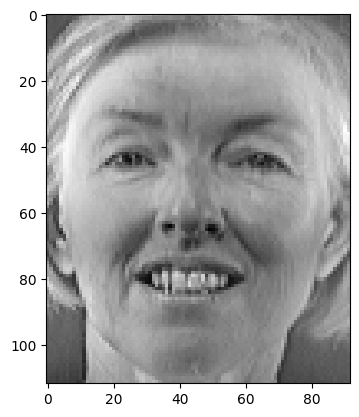

In [10]:
for i in range(0, 50, 10):
    plt.figure()
    plt.imshow(faces_nrm[i].reshape(face_shape), cmap="gray")

With `faces_nrm`, we can perform PCA on the faces.
Using the usual notation, the rows of `Vt` (corresponding to the columns of $V$ with the usual notation for SVD) are the right-singular vector. For this dataset, these are the standard face components that we can use to describe each face. Here, we display the first ten face components.

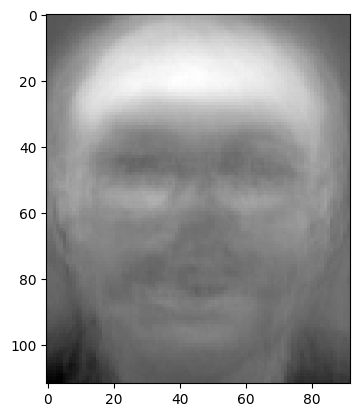

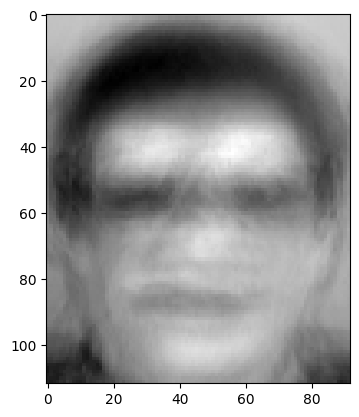

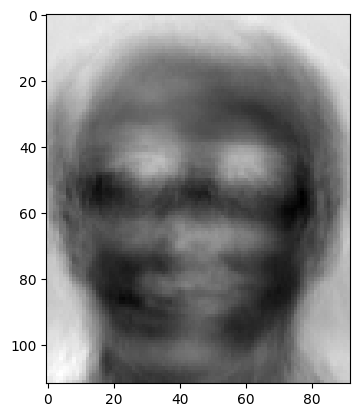

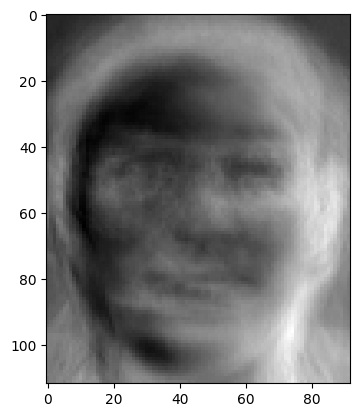

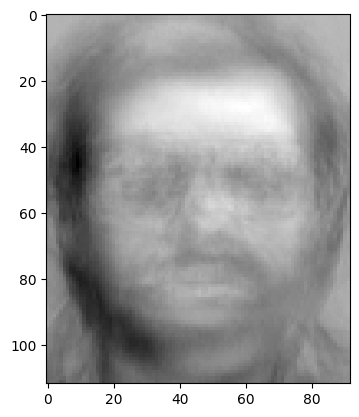

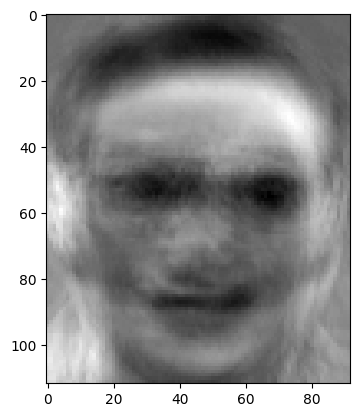

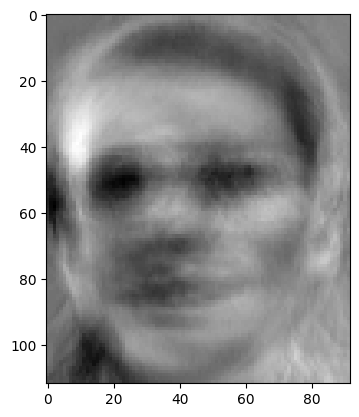

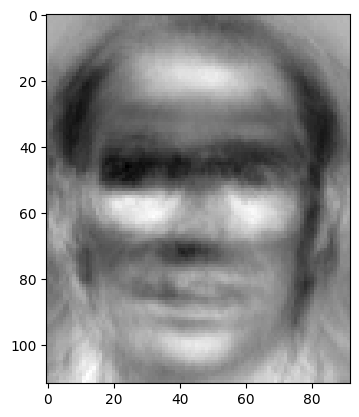

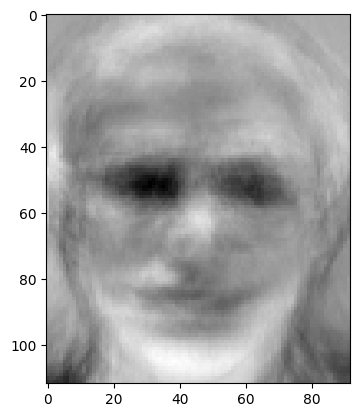

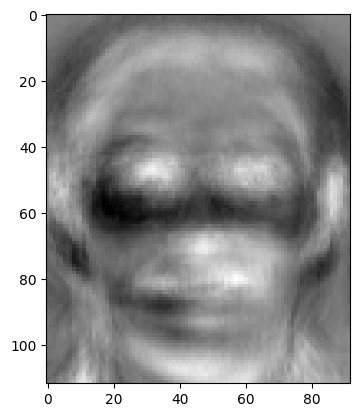

In [11]:
# Compute the SVD of the zero-mean dataset
U,S,Vt = la.svd(faces_nrm, full_matrices=False)

for i in range(10):
    plt.figure()
    plt.imshow(Vt[i].reshape(face_shape), cmap="gray")

## 2) Computing the principal component space

We now focus on the most important or *principal* components to balance expressivity and simplicity. This executes [dimension reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) to distill complex, high-dimensional data into their more salient parts: we search for a dataset's intrinsic dimension, in a sense.

The plot below is called a *Scree plot*, which displays the singular values in decreasing order. This will inform how extremely we should reduce the dimension of our dataset, though there is no correct answer---data science is, in part, a subjective art.

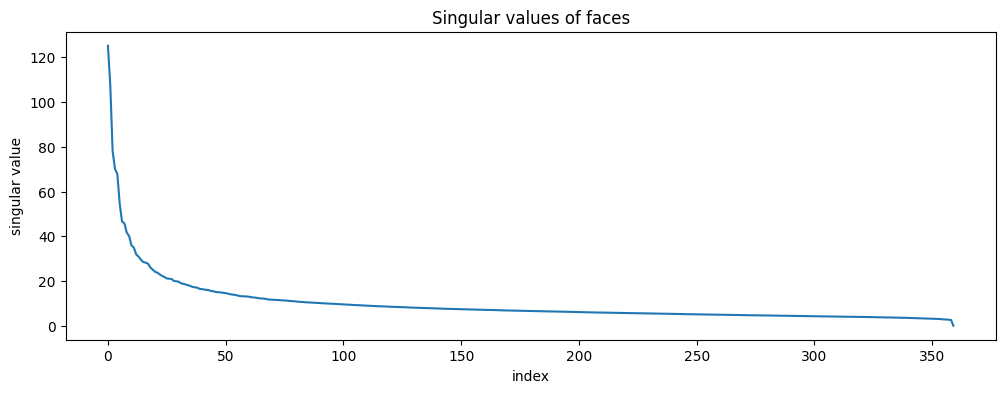

In [12]:
plt.figure(figsize=(12,4))
plt.plot(S, '-')
plt.xlabel('index')
plt.ylabel('singular value')
plt.title('Singular values of faces')
plt.show()

While there are multiple ways to determine good choices for the target dimension (i.e., how many principal components to consider), one heuristic is to pick an *elbow* from the Scree plot. Elbows are not well defined, but you may consider them as points in the Scree plot that considerably level off the slope.

To help pick the target dimension in this light, we plot the first 25 consecutive decreases in singular values below.

In [13]:
# Compute the vector of consecutive decreases among singular values
S_dec = S[:-1] - S[1:]

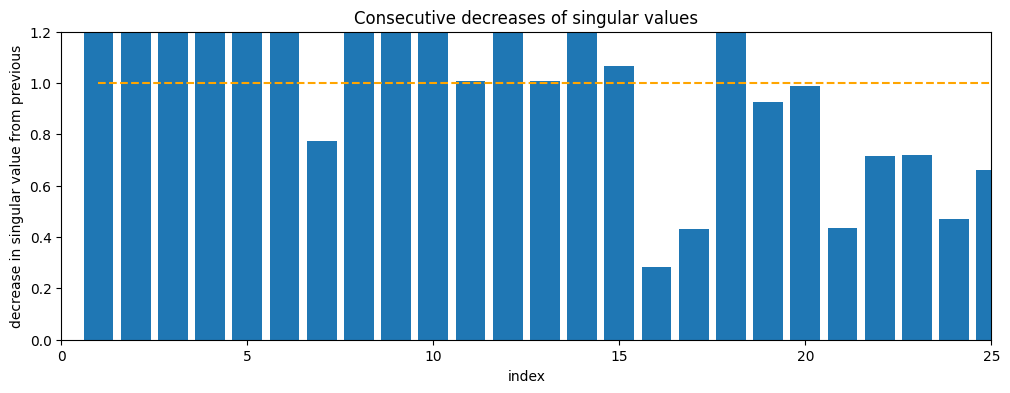

In [14]:
# Plot singular value decreases
plt.figure(figsize=(12,4))
m = 25
plt.bar(np.arange(len(S_dec))+1, S_dec)

# Plot y=1 line
xx = np.linspace(1,m,100)
plt.plot(xx, xx**0., '--', c='orange')

# Adjust plot parameters
plt.xlim(0,m)
plt.ylim(0,1.2) # Uncomment to zoom in y-axis view toward y=1 line
plt.xlabel('index')
plt.ylabel('decrease in singular value from previous')
plt.title('Consecutive decreases of singular values')
plt.show()

- Compute the dimension `d` as the index of the singular value which marks the first consecutive decrease falling below 1. **This step analyzes a plot.**

*We could compute this programmatically using `S_dec` or visually with the plot above (the orange dotted bar marks the value 1).*

*It's also important to note that the 0-entry of `S_dec` represents the decrease from the 0-singular value to the 1-singular value. If working programmatically, you might need to increment your index.*

In [15]:
d = 7
Vt.shape

(360, 10304)

In [16]:
print('We will work with {} principal components.'.format(d))

We will work with 7 principal components.


Now, we may construct a matrix comprising the principal components.Letting $v_i$ denote the $i$th right-singular vector, the matrix $V_d$ comprises the first $d$ right-singular vectors (principal components) as its columns:
$$V_d = \left(\begin{matrix}  \vert & \ & \vert  \\ v_0 & \cdots & v_{d-1} \\ \vert & \ & \vert \end{matrix}\right) . $$

- Compute the matrix $V_d$ with the value `d` computed above. Store this as the 2d NumPy array `Vd`. **This step truncates a matrix.**

In [17]:
# Use `Vt`, which represents $V^T$.
Vd = Vt[:d, :].T

We are now ready to compute the *principal components* of each of the faces using $V_d$.
Recall that right-matrix multiplication can be considered as projection onto the columnspace of a matrix.

Thus, by multiplying our normalized dataset `faces_nrm` on the right by $V_d$, we project the faces onto the space of principal components. The result is an array containing, for each face, the weight of each principal component for the face's composition. We now store this as the 2d NumPy array `faces_pc`. **It's important to note that this step computes principal component weights of training data.**

In [18]:
faces_pc = faces_nrm @ Vd

## 3. Facial recognition with a nearest-neighbor classifier

The [$k$-nearest neighbors (kNN) algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) is a supervised machine learning classifier that, once trained, considers an unlabeled data point in the feature space and classifies that point according to the plurality of classifications given to the point's $k$-many nearest neighbors.

For this part, we will build the kNN model for $k=1$, so we reduce to the case of nearest-neighbor (NN) classification. We will consider an unlabeled face image and identify the labeled face image lying closest to it in the space of principal component weights, then assign that face's label to the unknown face.

*N.B. In contrast to the machine learning algorithm used for matrix completion, this classifier is trained by one-off computations on the training data; there are no epochs to repeat.*

In [19]:
# Import data
unknown = np.loadtxt('./unknown_face.txt')

We provide the unknown face `unknown` in the usual format for a single face. This face was not included in the training set `faces`, but the person `unknown` belongs to did have other face images included there.

Unknown face.


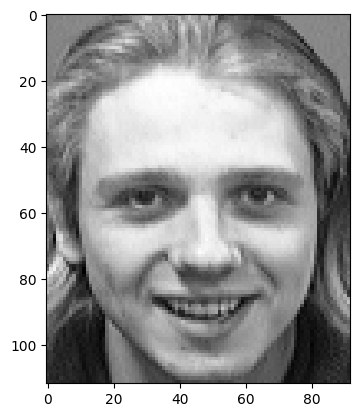

In [20]:
print('Unknown face.')
plt.figure()
plt.imshow(unknown.reshape(face_shape), cmap="gray")

- Use `unknown` to compute the vector of principal component weights for the unknown face. Store the result as the 1d NumPy array `unknown_pc`. **This step computes principal component weights of testing data.**

This means: 
- Before projecting onto the principal components space, we must apply the exact same changes applied to each face when you constructed `faces_norm` from `faces`.*

In [21]:
unknown_nrm = unknown - face_avg

unknown_pc = unknown_nrm @ Vd
unknown_pc.shape

(7,)

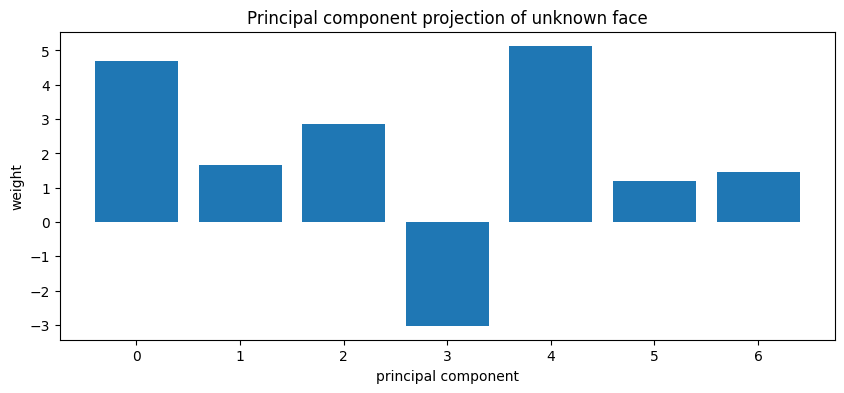

In [22]:
plt.figure(figsize=(10,4))
plt.bar(list(range(d)),height=unknown_pc)
plt.xlabel('principal component')
plt.ylabel('weight')
plt.title('Principal component projection of unknown face')
plt.show()

- Lastly, compute the index `n` of the known face whose principal component weights vector lies closest to that of the unknown face. **Note: step analyzes vectors of principal component weights.**

*In other words, find the index of the row from `faces_pc` that minimizes the norm of its difference with `unknown_pc`.*

*Note: Use [`numpy.linalg.norm`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) with default arguments to compute these norms. You might find [`numpy.argmin`](https://numpy.org/doc/stable/reference/generated/numpy.argmin.html) useful too, or you could use a for loop and track the least norm seen yet.*

In [23]:
diff = faces_pc - unknown_pc
norms = np.linalg.norm(diff, axis=1)
n = np.argmin(norms)

We can then use `labels` to determine the label of the most proximal face to the unknown face. This is the label we will bestow upon the unknown face.

In [24]:
unknown_label = labels[n]

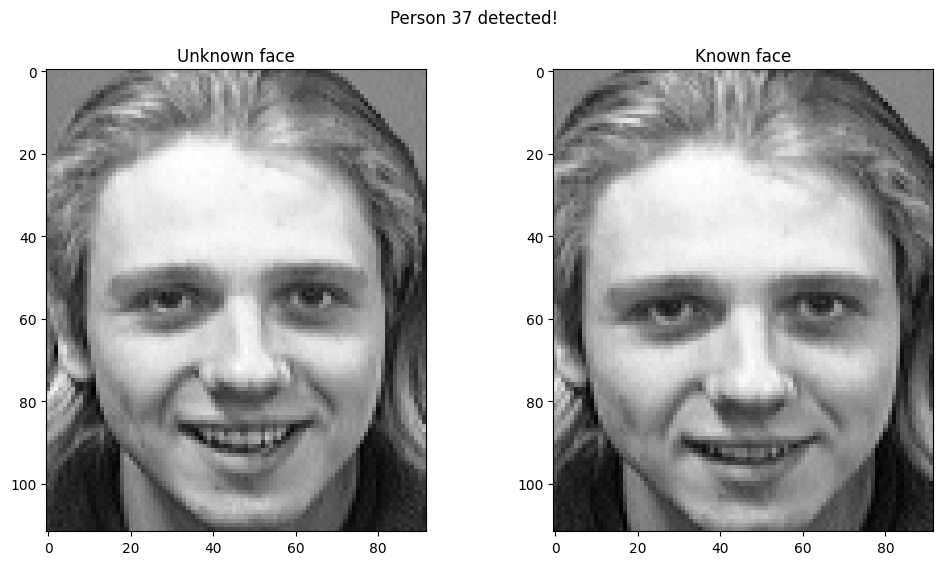

In [25]:
# Plot unknown face and most proximal face in principal component space
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
fig.suptitle('Person {} detected!'.format(unknown_label))
ax1.imshow(unknown.reshape(face_shape), cmap="gray")
ax1.set_title('Unknown face')
ax2.imshow(faces[n].reshape(face_shape), cmap="gray")
ax2.set_title('Known face')
plt.show()